In [1]:
import pandas as pd
import os
import shutil
from tqdm import tqdm
import librosa
import matplotlib.pyplot as plt
import soundfile as sf
from audiomentations import AddGaussianSNR,PitchShift, Compose,AddGaussianNoise,TimeStretch,Shift
import numpy as np
import tensorflow as tf
import data_utils as du
import seaborn as sns

sns.set_style("white")





2024-09-04 17:39:15.690895: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-04 17:39:15.693608: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-04 17:39:15.701420: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 17:39:15.715754: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 17:39:15.715787: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-04 17:39:15.726334: I tensorflow/core/platform/cpu_feature_guard.cc:

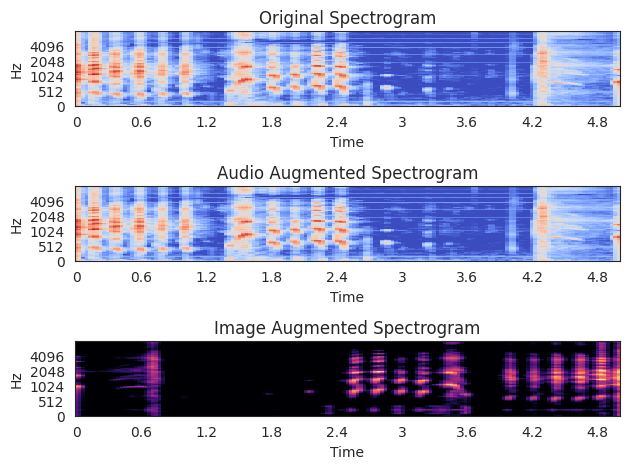

In [2]:

# Load an audio file
y,_=librosa.load('/mnt/ESC-50-master/audio_16k/1-73123-A-26.wav', sr=16000)

# get the mel spectrogram
original_spec=du.mel_layer(y)

# audio augmentation with audiomentations
transform = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_shift=-0.5, max_shift=0.5, p=0.5),
])

#apply the augmentation and get the mel spectrogram
augmented_sound = transform(y, sample_rate=16000)
augmented_spec=du.mel_layer(augmented_sound)


# image augmentation with keras preprocessing layers
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomBrightness(0.1),
  tf.keras.layers.RandomTranslation(0.1, 0.1),
  tf.keras.layers.RandomContrast(0.4)])

#apply the augmentation on the original mel spectrogram
image_aug=data_augmentation(original_spec)


# plot the original, audio augmented and image augmented spectrograms
fig, axs = plt.subplots(3)

librosa.display.specshow(original_spec[:,:,0].numpy(), sr=16000, x_axis='time', y_axis='mel', ax=axs[0])
axs[0].set_title('Original Spectrogram')

librosa.display.specshow(augmented_spec[:,:,0].numpy(), sr=16000, x_axis='time', y_axis='mel', ax=axs[1])
axs[1].set_title('Audio Augmented Spectrogram')

librosa.display.specshow(image_aug[:,:,0].numpy(), sr=16000, x_axis='time', y_axis='mel', ax=axs[2])
axs[2].set_title('Image Augmented Spectrogram')

plt.tight_layout()
#plt.savefig('imgs/preprocessing.png')
plt.show()


In [3]:
keywords = ['original','audio','img']
logs_file = os.listdir('logs')
results = pd.DataFrame(columns=['original','audio','img'],index=['cnn','lstm','attention'])
#add model name as row index
for file in logs_file:
    df = pd.read_csv('logs/'+file)
    #print(file,df['val_accuracy'].max())
    for key in keywords:
        if key in file:
            if "attention" in file:
                results.loc["attention",key]=df['val_accuracy'].max()
            elif "lstm" in file:
                results.loc["lstm",key]=df['val_accuracy'].max()
            else:
                results.loc["cnn",key]=df['val_accuracy'].max()

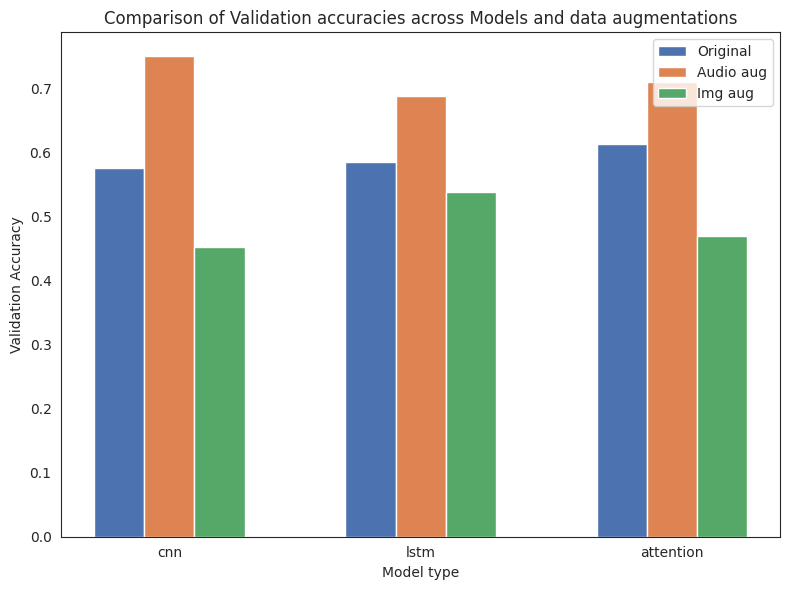

In [5]:
df=results
# Setting the positions and width for the bars
x = np.arange(len(df.index))  # the label locations
width = 0.2  # the width of the bars

# Plotting the bars
fig, ax = plt.subplots(figsize=(8, 6))
#fig color palette
sns.set_palette("husl")
rects1 = ax.bar(x - width, df['original'], width, label='Original')
rects2 = ax.bar(x, df['audio'], width, label='Audio aug')
rects3 = ax.bar(x + width, df['img'], width, label='Img aug')

# Adding labels, title, and custom x-axis tick labels
ax.set_xlabel('Model type')
ax.set_ylabel('Validation Accuracy')
ax.set_title('Comparison of Validation accuracies across Models and data augmentations')
ax.set_xticks(x)
ax.set_xticklabels(df.index)
ax.legend()

# Show the plot
plt.tight_layout()
plt.savefig('imgs/comparison.png')
plt.show()

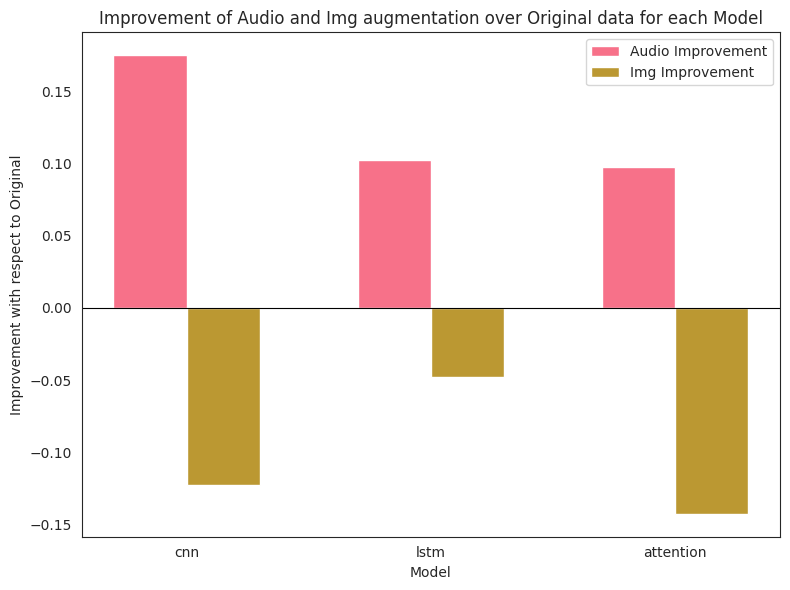

In [6]:

# Calculate the improvement with respect to Original
df['Audio Improvement'] = df['audio'] - df['original']
df['Img Improvement'] = df['img'] - df['original']

# Setting the positions and width for the bars
x = np.arange(len(df.index))  # the label locations
width = 0.3  # the width of the bars

# Plotting the bars
fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, df['Audio Improvement'], width, label='Audio Improvement')
rects2 = ax.bar(x + width/2, df['Img Improvement'], width, label='Img Improvement')

# Adding labels, title, and custom x-axis tick labels
ax.set_xlabel('Model')
ax.set_ylabel('Improvement with respect to Original')
ax.set_title('Improvement of Audio and Img augmentation over Original data for each Model')
ax.set_xticks(x)
ax.set_xticklabels(df.index)
ax.axhline(0, color='black', linewidth=0.8)  # Adding a horizontal line at y=0
ax.legend()

# Show the plot
plt.tight_layout()
plt.savefig('imgs/improvement.png')
plt.show()

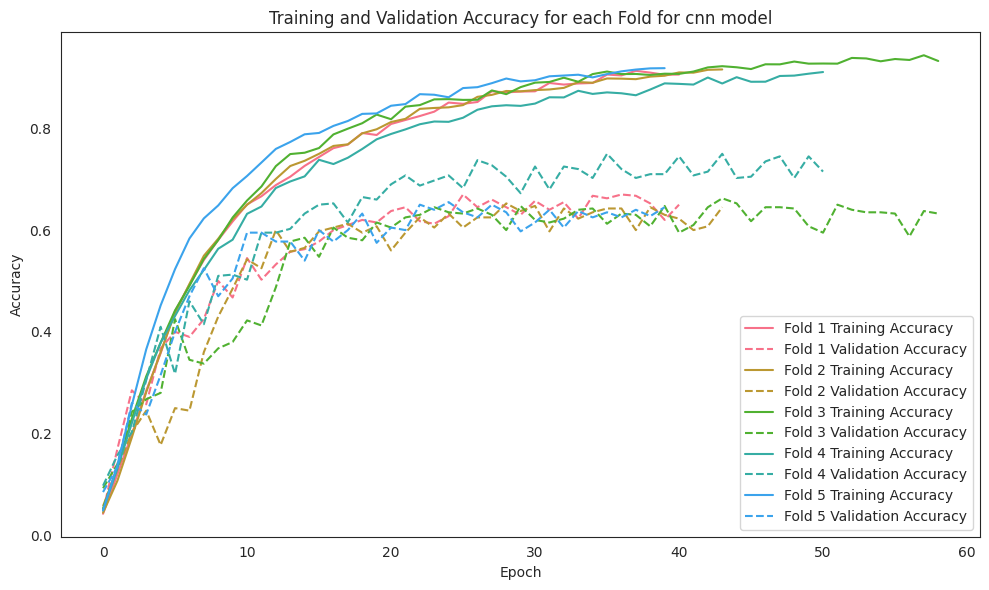

In [7]:

df=pd.read_csv('logs/cnn_training_16k_audio.log')

#add fold column
df['fold']=0
fold=0
for i in range(len(df)):
    # check when the epoch is zero and add the fold number
    if df['epoch'][i]==0:
        fold+=1

    df.loc[i,'fold']=fold

# plot the training and validation accuracy for each fold, in one graph
fig, ax = plt.subplots()
#figsize
ax.figure.set_size_inches(10, 6)
for i in range(1,6):
    fold_logs=df[df['fold']==i]
    #same color for training and validation in the same fold
    ax.plot(fold_logs['epoch'], fold_logs['accuracy'], label=f'Fold {i} Training Accuracy', color='C'+str(i-1))
    ax.plot(fold_logs['epoch'], fold_logs['val_accuracy'], label=f'Fold {i} Validation Accuracy', color='C'+str(i-1), linestyle='--')



ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Training and Validation Accuracy for each Fold for cnn model')
ax.legend()
plt.tight_layout()
plt.savefig('imgs/training_curve.png')
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step


2024-09-04 17:39:57.614643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


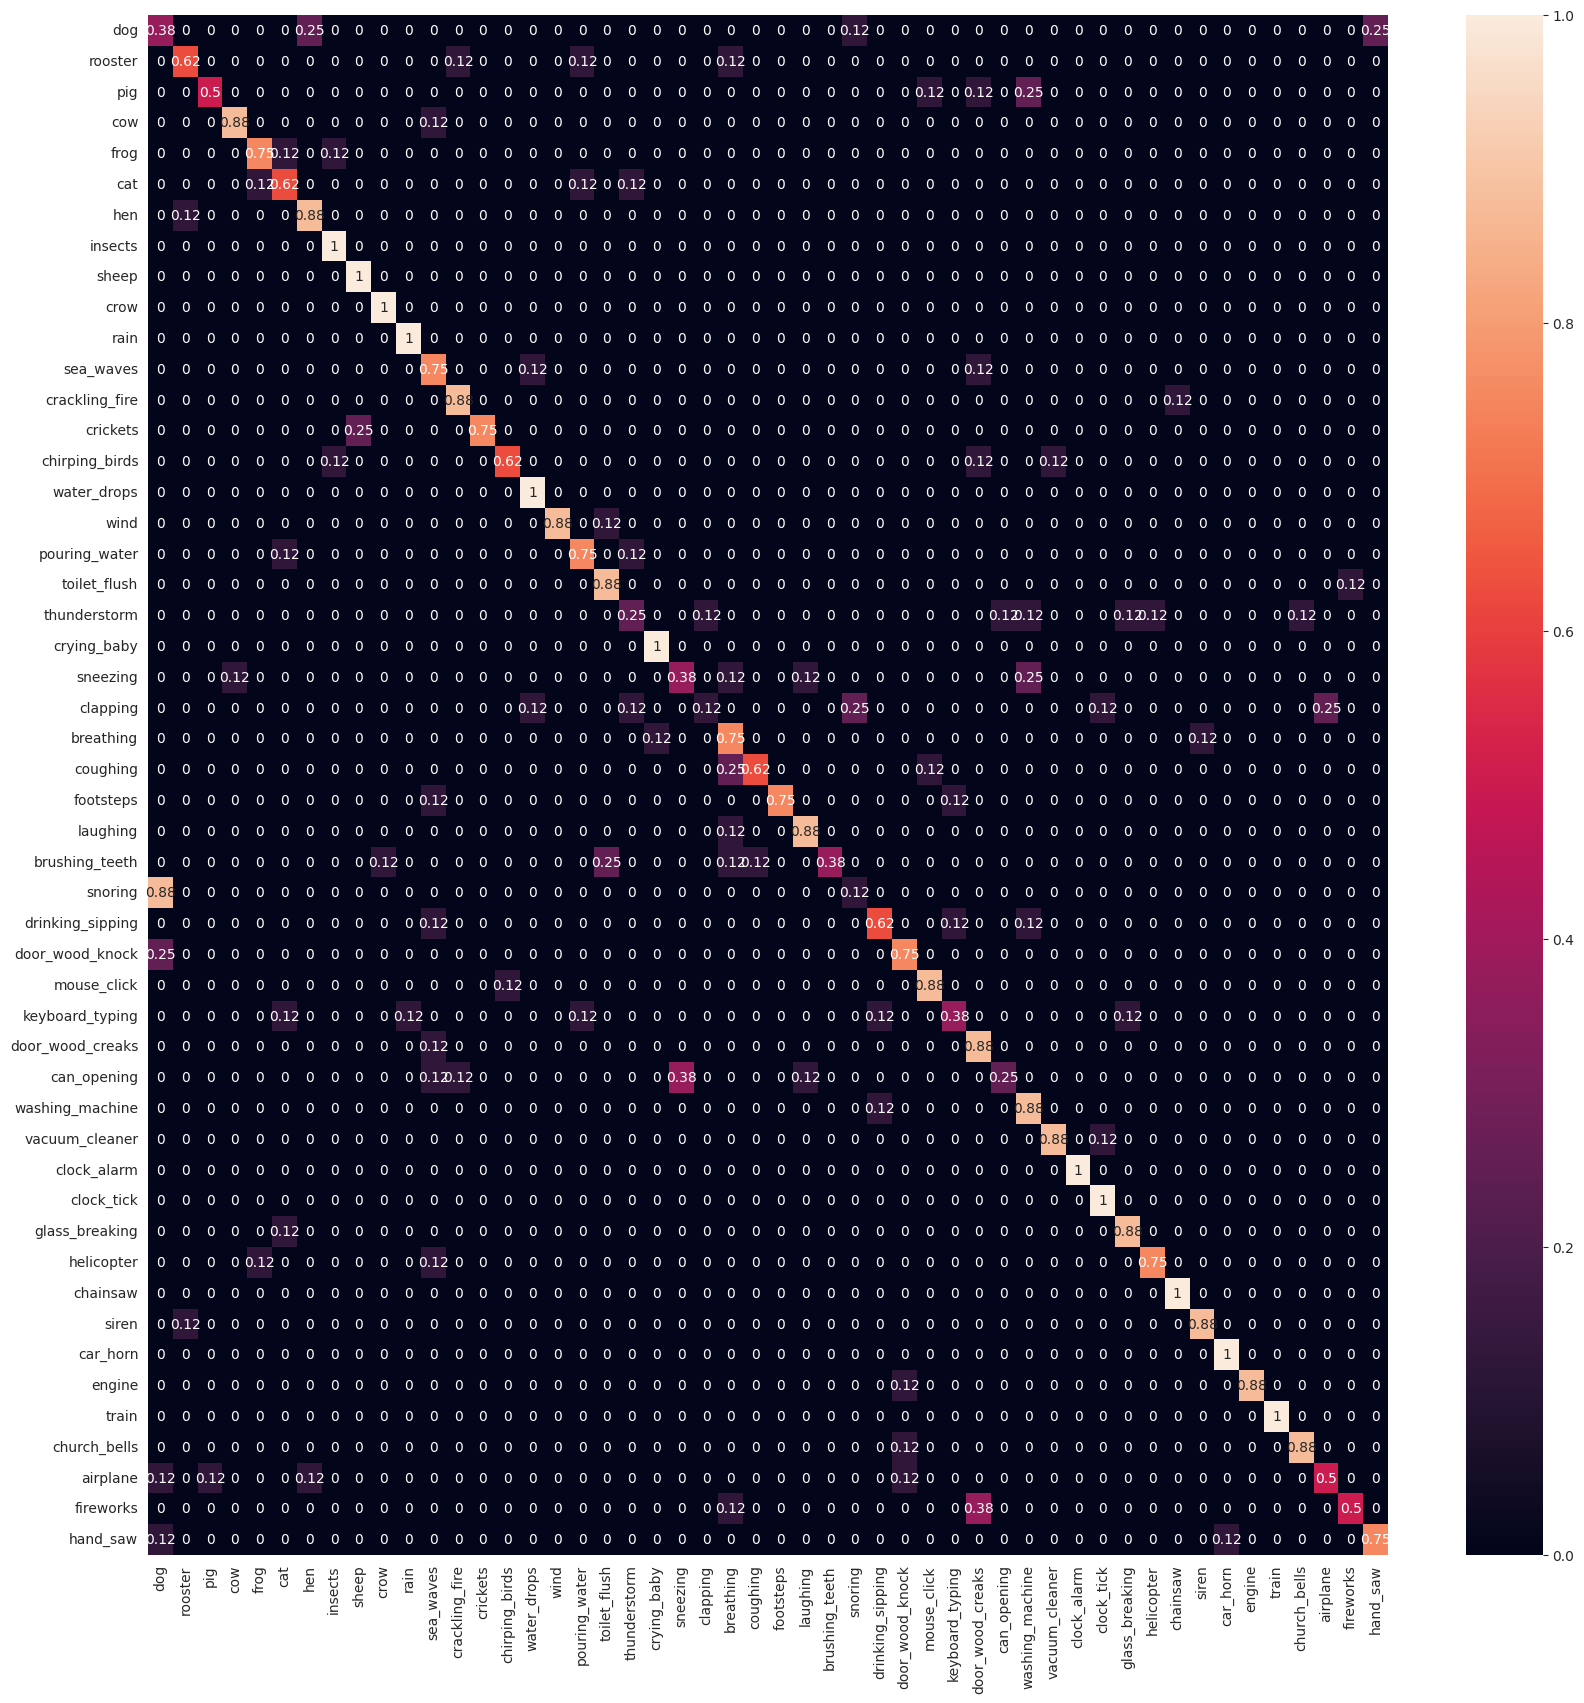

In [8]:

data_path="/mnt/ESC-50-master/audio_16k_aug_r4/esc50_augmented_r4.csv"
audio_path="/mnt/ESC-50-master/audio_16k_aug_r4/"

#check in which fold the model performed the best
fold_idx=df.groupby('fold')['val_accuracy'].max().idxmax()
#load the best model
model=tf.keras.models.load_model(f'models/cnn_model_audio_{fold_idx}.keras')

metadata=pd.read_csv(data_path)
metadata["filename"] = metadata["filename"].apply(lambda x: audio_path + x)
batch_size=128*3

train_ds, val_ds = du.get_fold(metadata,fold_idx,batch_size,shuffle=False)

du.plot_confusion_matrix(val_ds,model,metadata)



In [8]:
from models import cnn,cnn_lstm_attention,cnn_lstm

models = [cnn,cnn_lstm,cnn_lstm_attention]

for model_name in models:
    model = model_name(train_ds,du.get_shape(train_ds))
    #total number of parameters
    total_params = model.count_params()
    if model_name==cnn:
        results.loc["cnn","params"]=total_params
    elif model_name==cnn_lstm:
        results.loc["lstm","params"]=total_params
    else:
        results.loc["attention","params"]=total_params

2024-09-04 17:12:18.050174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-09-04 17:12:21.184881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-09-04 17:12:24.320131: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
results.to_csv('results.csv')